In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Question 10

In [2]:
!pip install cvxopt


     |████████████████████████████████| 11.6 MB 2.4 MB/s 
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from cvxopt import solvers, matrix

In [4]:
#setup from 1-9

In [5]:
#starting matrices
reward1 = np.zeros((10,10))
reward2 = np.zeros((10,10))


reward1[9][9] = 1

reward2[9][9]=10
reward2[1][5]=reward2[1][6]= -100

for i in [1,2,3,4,5,6]:
    reward2[i][4]=-100
    
reward2[2][6]= -100
reward2[3][6]= -100
reward2[3][7]= -100
reward2[3][8]=-100

for i in [4,5,6,7]:
    reward2[i][8]=-100
    
reward2[7][6]= -100 
reward2[7][7]= -100
reward2[8][6]= -100



In [6]:
import numpy as np
import matplotlib.pyplot as plt
from cvxopt import matrix, solvers


def probability(current_state, next_state, move, prob):

    right = current_state + action_set[0]
    left = current_state + action_set[1]
    up = current_state + action_set[2]
    down = current_state + action_set[3]
    if next_state == left:
        if move == 0:
            return 1-prob+prob/4
        else:
            return prob/4
    elif next_state == up:
        if move == 1:
            return 1-prob+prob/4
        else:
            return prob/4
    elif next_state == right:
        if move == 2:
            return 1-prob+prob/4
        else:
            return prob/4
    elif next_state == down:
        if move == 3:
            return 1-prob+prob/4
        else:
            return prob/4
    elif next_state == current_state:
        record = 0
        if left < 0:
            if move == 0:
                record += (1-prob+prob/4)
            else:
                record += prob/4
        if right > 99:
            if move == 2:
                record += (1-prob+prob/4)
            else:
                record += prob/4
        if up % 10 == 9:
            if move == 1:
                record += (1-prob+prob/4)
            else:
                record += prob/4
        if down % 10 == 0:
            if move == 3:
                record += (1-prob+prob/4)
            else:
                record += prob/4
        return record
    else:
        return 0


# Procedure Value Iteration
def compute(current_state, move, prob, discount_factor, reward, values):
    right = current_state + action_set[0]
    left = current_state + action_set[1]
    up = current_state + action_set[2]
    down = current_state + action_set[3]
    neighbours = [right, left, up, down, current_state]
    result = 0
    for neigh in neighbours:
        if neigh < 0 or neigh > 99 or (current_state % 10 == 0 and neigh % 10 == 9) or (current_state % 10 == 9 and neigh % 10 == 0):
            continue
        result += probability(current_state, neigh, move, prob) * (reward[neigh] + discount_factor * values[neigh])
    return result


def optimal_state_val(values, random_probability_w, discount_factor, reward, threshold):
    # 1) Initialization
    for state in range(100):
        values[state] = 0
    # 2) Estimation
    delta = float('inf')
    while delta > threshold:
        delta = 0
        temp = values[:]
        for state in range(100):
            v = values[state]
            values[state] = max(compute(state, 0, random_probability_w, discount_factor, reward, temp),
                                compute(state, 1, random_probability_w, discount_factor, reward, temp),
                                compute(state, 2, random_probability_w, discount_factor, reward, temp),
                                compute(state, 3, random_probability_w, discount_factor, reward, temp))
            delta = max(delta, abs(v - values[state]))
    return values

def raw_matrix(length, random_probability_w, direction):
    s = length * length
    res = np.zeros(s * s).reshape(s, s)
    main_possibility = 1 - random_probability_w
    random_possibility = random_probability_w / 4
    for row in range(s):
        #######################
        nexts = next_states(length, row)
        if direction == "left":
            res[row][nexts[0]] = main_possibility
        elif direction == "down":
            res[row][nexts[1]] = main_possibility
        elif direction == "right":
            res[row][nexts[2]] = main_possibility
        elif direction == "up":
            res[row][nexts[3]] = main_possibility
        for col in nexts:
            res[row][col] += random_possibility
            ######################################
    return res
        
def next_states(length, cur_state):
    x = cur_state % length
    y = cur_state // length
    up = cur_state - 1
    down = cur_state + 1
    left = cur_state - length
    right = cur_state + length
    if x == 0:
        up = cur_state
    if x == length - 1:
        down = cur_state
    if y == 0:
        left = cur_state
    if y == length - 1:
        right = cur_state
    return np.array([left, down, right, up])
def get_c_D_b(exp_action, P_actions, lam, rmax):
    P_exp = []
    P_ags = []
    P_ags.append([])
    P_ags.append([])
    P_ags.append([])
    for state in range(100):
        exp_act = exp_action[state]
        agent = 0
        for action in range(4):
            if action == exp_act:
                P_exp.append(P_actions[action][state])
            else:
                P_ags[agent].append(P_actions[action][state])
                agent += 1

    I = np.eye(100)
    zero = np.zeros(100 * 100).reshape(100, 100)
    D = np.concatenate((zero, zero, zero, zero))
    D = np.concatenate((D, np.concatenate((-I, -I, zero, zero)), 
                        np.concatenate((I, -I, I, -I))), 1)
 
    for Pa in P_ags:
        temp = np.dot((np.array(Pa) - np.array(P_exp)), 
                      np.linalg.inv(np.eye(100) - 0.8 * np.array(P_exp)))
        temp_row1 = np.concatenate((I, zero, temp), 1)
        temp_row2 = np.concatenate((zero, zero, temp), 1)
        temp = np.concatenate((temp_row1, temp_row2))
        D = np.concatenate((temp, D))
        
    c1 = np.array([1. for _ in range(100)])
    c2 = np.array([-lam for _ in range(100)])
    c3 = np.array([0.0 for _ in range(100)])
    c = np.concatenate((c1, c2, c3), axis=0)
    c = -c
    b1 = np.array([0.0 for _ in range(800)])
    b2 = np.array([rmax for _ in range(200)])
    b = np.concatenate((b1, b2), axis=0)
    return c, D, b

def get_reward(c, D, b):
    A = matrix(D)
    b = matrix(b)
    c = matrix(c)
    solvers.options['show_progress'] = False
    sol=solvers.lp(c,A,b)
    return sol['x'][-100:]


def sweep(exp_action, rmax):
    acc_list = []
    lam_list = []
    lam = 0
    for i in range(501):
        c, D, b = get_c_D_b(exp_action, P_acts, lam, rmax)
        reward = np.array(get_reward(c, D, b))
        value = optimal_state_val(values, random_probability_w, discount_factor, reward, thresh_val)
        # OA
        agent_action = [0 for _ in range(100)]
        for state in range(100):
            agent_action[state] = np.argmax([compute(state, 0, random_probability_w, discount_factor, reward, value),
                                             compute(state, 1, random_probability_w, discount_factor, reward, value),
                                             compute(state, 2, random_probability_w, discount_factor, reward, value),
                                             compute(state, 3, random_probability_w, discount_factor, reward, value)])
        count = 0
        for j, k in zip(exp_action, agent_action):
            if j == k:
                count += 1
        acc = count / len(agent_action)
        
        print("lambda: " + str(lam) + "  acc: " + str(acc))
        acc_list.append(acc)
        lam_list.append(lam)
        lam += 0.01
    return lam_list, acc_list

In [7]:
values = [0 for _ in range(100)]
thresh_val = 0.01

state_space = np.tile(np.arange(0, 100, 10), (10, 1)) + np.arange(0, 10, 1).reshape((10, 1))
discount_factor = 0.8
random_probability_w = 0.1
UP = -1
DOWN = 1
LEFT = -10
RIGHT = 10
action_set = [RIGHT, LEFT, UP, DOWN]
#actions = [-10, -1, 10, 1] # left, up, right, down

lambda: 0  acc: 0.82
lambda: 0.01  acc: 0.81
lambda: 0.02  acc: 0.81
lambda: 0.03  acc: 0.81
lambda: 0.04  acc: 0.81
lambda: 0.05  acc: 0.81
lambda: 0.060000000000000005  acc: 0.73
lambda: 0.07  acc: 0.73
lambda: 0.08  acc: 0.73
lambda: 0.09  acc: 0.73
lambda: 0.09999999999999999  acc: 0.73
lambda: 0.10999999999999999  acc: 0.73
lambda: 0.11999999999999998  acc: 0.73
lambda: 0.12999999999999998  acc: 0.73
lambda: 0.13999999999999999  acc: 0.73
lambda: 0.15  acc: 0.73
lambda: 0.16  acc: 0.73
lambda: 0.17  acc: 0.73
lambda: 0.18000000000000002  acc: 0.73
lambda: 0.19000000000000003  acc: 0.74
lambda: 0.20000000000000004  acc: 0.72
lambda: 0.21000000000000005  acc: 0.72
lambda: 0.22000000000000006  acc: 0.73
lambda: 0.23000000000000007  acc: 0.73
lambda: 0.24000000000000007  acc: 0.73
lambda: 0.25000000000000006  acc: 0.73
lambda: 0.26000000000000006  acc: 0.73
lambda: 0.2700000000000001  acc: 0.73
lambda: 0.2800000000000001  acc: 0.73
lambda: 0.2900000000000001  acc: 0.73
lambda: 0.30000

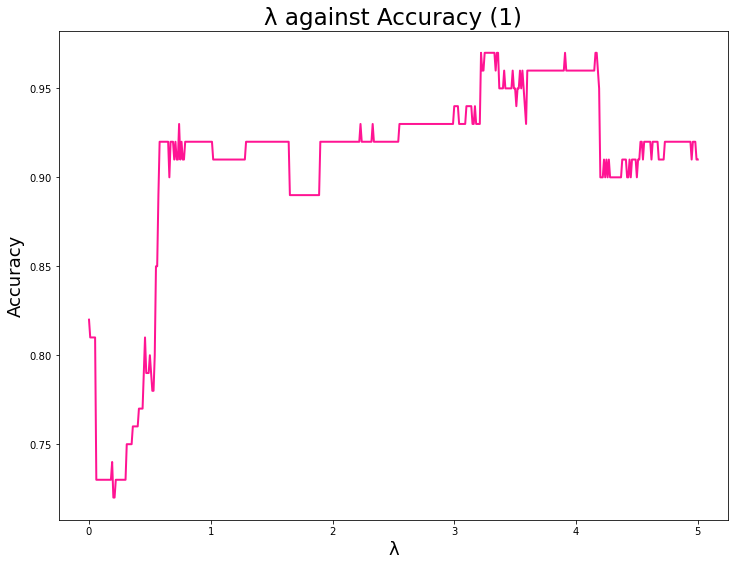

In [8]:


# record expert actions
reward_1 = []
reward1 = np.array(reward1).transpose()
for lines in reward1:
    reward_1 += list(lines)
exp_action = [0 for _ in range(100)]
values = optimal_state_val(values, random_probability_w, discount_factor, reward_1, thresh_val)
for state in range(100):
    exp_action[state] = np.argmax([compute(state, 0, random_probability_w, discount_factor, reward_1, values),
                                   compute(state, 1, random_probability_w, discount_factor, reward_1, values),
                                   compute(state, 2, random_probability_w, discount_factor, reward_1, values),
                                   compute(state, 3, random_probability_w, discount_factor, reward_1, values)])

P_acts = []
P_acts.append(raw_matrix(10, 0.1, "left"))
P_acts.append(raw_matrix(10, 0.1, "up"))
P_acts.append(raw_matrix(10, 0.1, "right"))
P_acts.append(raw_matrix(10, 0.1, "down"))

lam_list, acc_list = sweep(exp_action, 1.0)

# plot figure
plt.figure(figsize=(12,9))
plt.xlabel('λ', fontsize=18)
plt.ylabel('Accuracy', fontsize=18)
plt.title('λ against Accuracy (1)', fontsize=23)
plt.plot(lam_list, acc_list, color="deeppink", lw=2)
plt.show()

# Question 12

In [9]:
max_index = np.argmax(acc_list)
lam_max = lam_list[max_index]
print('Lambda value with maximum accuracy: ' + str(lam_max))

Lambda value with maximum accuracy: 3.2199999999999753


# Question 13

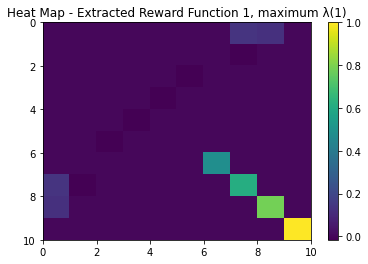

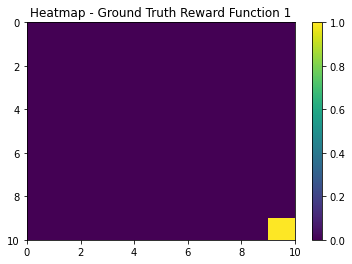

In [10]:
c_mat, D_mat, b_mat = get_c_D_b(exp_action, P_acts, lam_max, 1.0)
reward_opt = np.array(get_reward(c_mat, D_mat, b_mat))
reward_opt_graph = reward_opt.reshape(10, 10).T
plt.pcolor(reward_opt_graph)
plt.gca().invert_yaxis()
plt.colorbar()
plt.title("Heat Map - Extracted Reward Function 1, maximum λ(1)")
plt.show()

plt.pcolor(reward1)
plt.gca().invert_yaxis()
plt.colorbar()
plt.title("Heatmap - Ground Truth Reward Function 1")
plt.show()

# Question 14

Text(0.5, 1.0, 'Heat Map - Optimal State values, Extracted Reward Function 1')

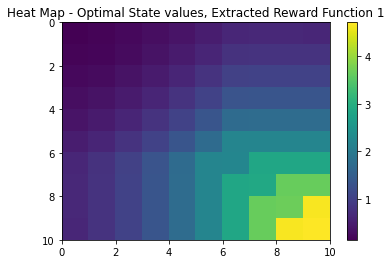

In [11]:
val_plot1 = optimal_state_val(values, random_probability_w, discount_factor, reward_opt, thresh_val)
g1 = np.round(val_plot1, decimals=3).reshape(10, 10).transpose()
plt.figure()
plt.pcolor(g1)
plt.gca().invert_yaxis()
plt.colorbar()
plt.title("Heat Map - Optimal State values, Extracted Reward Function 1")

# Question 16

In [12]:
##

# Question 18

lambda: 0  acc: 0.82
lambda: 0.01  acc: 0.8
lambda: 0.02  acc: 0.78
lambda: 0.03  acc: 0.79
lambda: 0.04  acc: 0.78
lambda: 0.05  acc: 0.78
lambda: 0.060000000000000005  acc: 0.8
lambda: 0.07  acc: 0.84
lambda: 0.08  acc: 0.83
lambda: 0.09  acc: 0.83
lambda: 0.09999999999999999  acc: 0.84
lambda: 0.10999999999999999  acc: 0.83
lambda: 0.11999999999999998  acc: 0.81
lambda: 0.12999999999999998  acc: 0.81
lambda: 0.13999999999999999  acc: 0.79
lambda: 0.15  acc: 0.79
lambda: 0.16  acc: 0.81
lambda: 0.17  acc: 0.81
lambda: 0.18000000000000002  acc: 0.82
lambda: 0.19000000000000003  acc: 0.82
lambda: 0.20000000000000004  acc: 0.83
lambda: 0.21000000000000005  acc: 0.82
lambda: 0.22000000000000006  acc: 0.83
lambda: 0.23000000000000007  acc: 0.83
lambda: 0.24000000000000007  acc: 0.83
lambda: 0.25000000000000006  acc: 0.89
lambda: 0.26000000000000006  acc: 0.89
lambda: 0.2700000000000001  acc: 0.88
lambda: 0.2800000000000001  acc: 0.88
lambda: 0.2900000000000001  acc: 0.88
lambda: 0.3000000

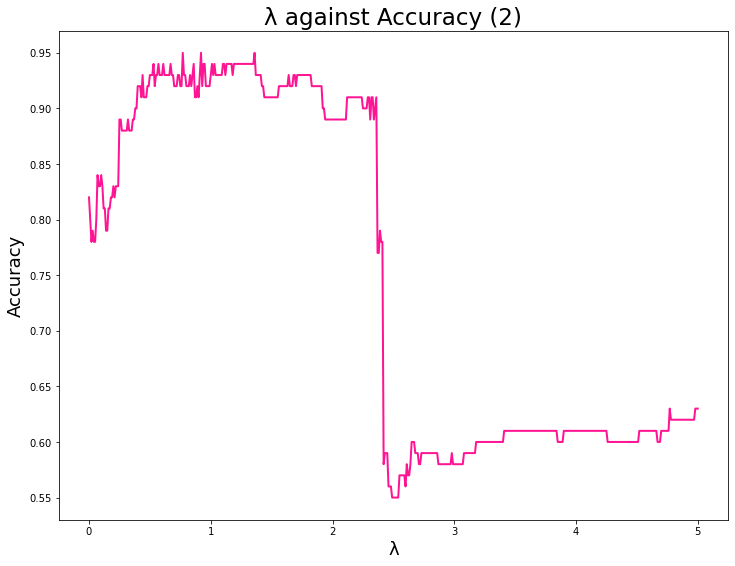

In [13]:
reward2_placeholder = []
reward_2_int = np.array(reward2).transpose()
for lines in reward_2_int:
    reward2_placeholder += list(lines)
exp_action2 = [0 for _ in range(100)]

val_plot2 = optimal_state_val(values, random_probability_w, discount_factor, reward2_placeholder, thresh_val)
for state in range(100):
    exp_action2[state] = np.argmax([compute(state, 0, random_probability_w, discount_factor, reward2_placeholder, val_plot2),
                                   compute(state, 1, random_probability_w, discount_factor, reward2_placeholder, val_plot2),
                                   compute(state, 2, random_probability_w, discount_factor, reward2_placeholder, val_plot2),
                                   compute(state, 3, random_probability_w, discount_factor, reward2_placeholder, val_plot2)])

lam_list2, acc_list2 = sweep(exp_action2, 100)

# plot figure
plt.figure(figsize=(12,9))
plt.xlabel('λ', fontsize=18)
plt.ylabel('Accuracy', fontsize=18)
plt.title('λ against Accuracy (2)', fontsize=23)
plt.plot(lam_list2, acc_list2, color="deeppink", lw=2)
plt.show()